# Lecture 2

Load up a nice Python environment, with high-resolution plots for a modern LCD:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


We are going to be trying to fit and extract some information from the public data released for GW150914.  First a disclaimer: this *is not what LIGO actually does*; our "just so" stories are significantly more sophisticated than what we will do here.  If you want to know what was actually done to fit the recent BBH events, you can read about it in our papers, particularly:

 * The GW150914 discovery paper [here](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)
 * The "parameter estimation" paper for GW150914 [here](https://arxiv.org/abs/1602.03840v2)
 * The discovery papers for [GW151226](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.241103), [GW170104](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.221101), and the lesser-significance (I want to believe it's a gravitational wave, but you are free to form your own opinions) [LVT151012](http://arxiv.org/abs/1606.04856v3)
 
and (of course) references therein.  Here we are just trying to give a flavour of the analysis.

We will be partially following the [BBH Event Tutorial](https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html) from the [LIGO Open Science Center](http://losc.ligo.org) [tutorial](https://losc.ligo.org/tutorials/) page.  I encourage you to read the whole tutorial at LOSC and, generally, to explore our data releases (one for each "GW" event) and the tools we have provided for learning from them.  

You will need to download the large files containing 4096 seconds of data surrounding GW150914 yourself (I am not putting them in the [git repository](https://github.com/farr/GWDataAnalysisSummerSchool) where these lectures are archived because they are quite large):
 * [Hanford data at 4096 Hz sampling](https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5)
 * [Hanford data at 16384 Hz sampling](https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5)
 * [Livingston data at 4096 Hz sampling](https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5)
 * [Livingston data at 16384 Hz sampling](https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126259446-32.hdf5)
 * [a Python library](https://losc.ligo.org/s/sample_code/readligo.py) to read in the data (you will also need [h5py](http://www.h5py.org) since the data files are stored in HDF5 format).
 
As in lecture 1, you will need to install the [seaborn](https://seaborn.pydata.org) library for pretty and useful statistical plots.

In [22]:
import h5py
import pystan
import scipy.interpolate as si
import scipy.signal as ss
import seaborn as sns
import readligo as rl

Make the plots pretty for the notebook:

In [7]:
sns.set_context('talk') # sns.set_context('notebook') will work better if you are following along at home
sns.set_style('ticks')
sns.set_palette('colorblind')

In [8]:
strain_h1, time_h1, channels_h1 = rl.loaddata('H-H1_LOSC_4_V1-1126259446-32.hdf5', 'H1')
fsampling = 4096
dt_sampling = time_h1[1]-time_h1[0]

This doesn't look like a gravitational wave at all:

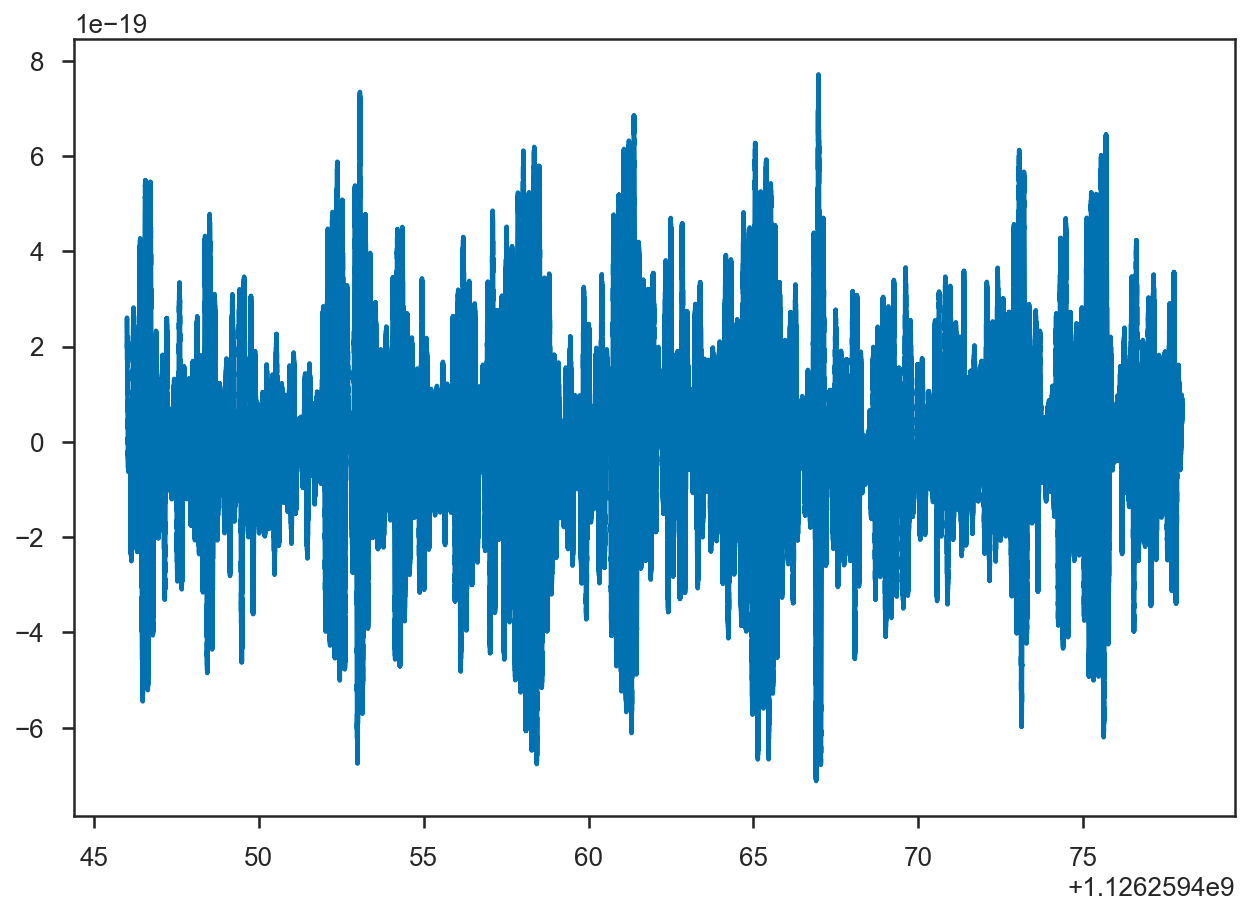

In [9]:
plot(time_h1, strain_h1)

The problem is that the LIGO data are dominated by *low frequency noise*, *calibration lines*, and other *narrowband detector lines*.  Fortunately, none of this noise "looks like" a GW signal.

 * Discuss "PSD," "stationarity," etc.
 * Formalise a bit "looks like."

Let's estimate the PSD for this data.  Since we know in advance that we are going to be interested in about 0.25 seconds around GW150914, we will use this "segment length" in the PSD estimate:

In [10]:
fs, psd_h1 = ss.welch(strain_h1, nperseg=fsampling/4, fs=fsampling)

(10, 2797.650445833001, 2.2231005898503085e-47, 1e-40)

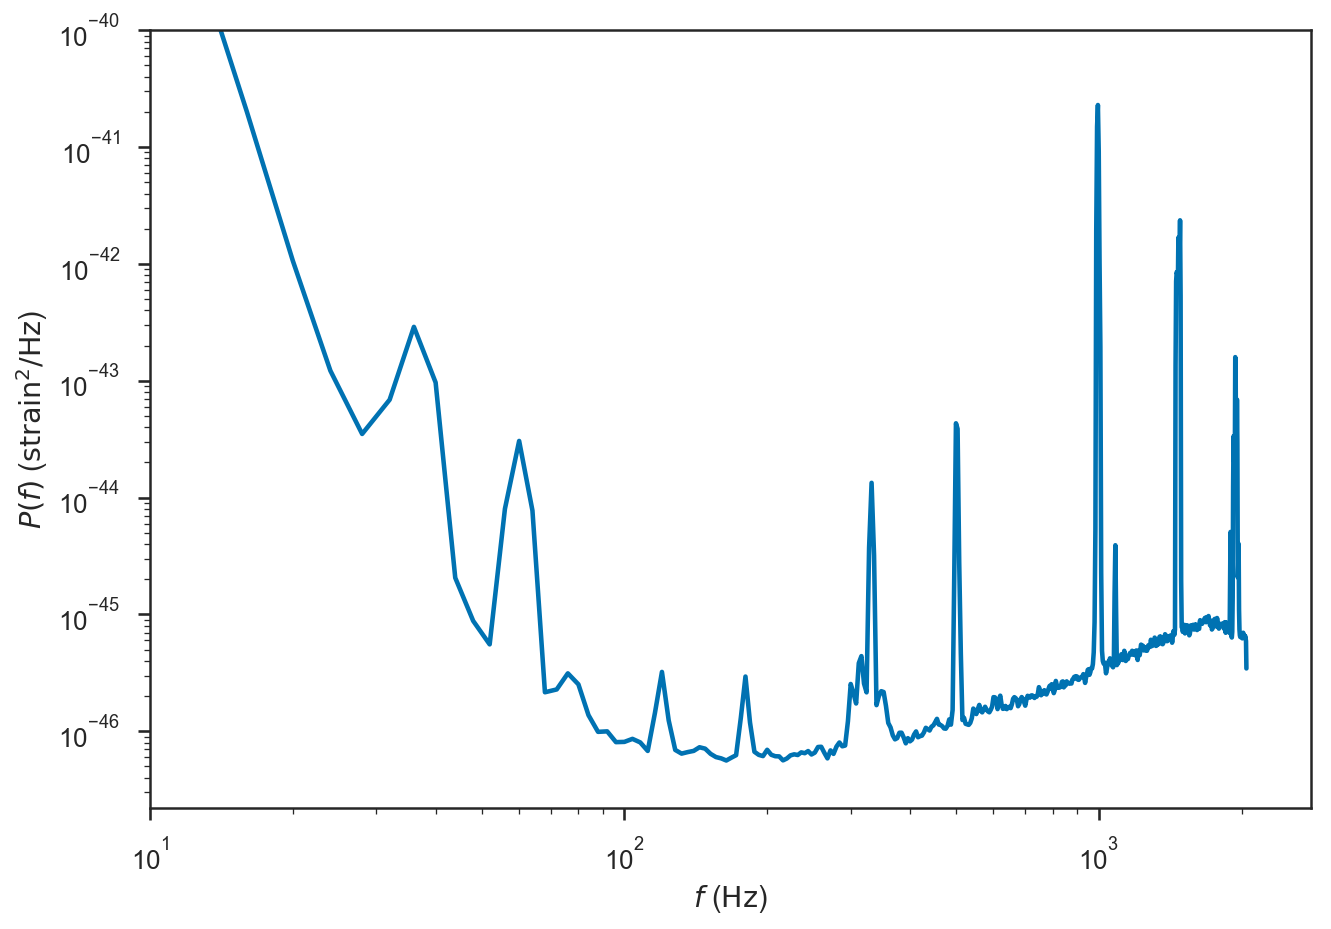

In [14]:
loglog(fs, psd_h1)
ylabel(r'$P(f)$ ($\mathrm{strain}^2 / \mathrm{Hz}$)')
xlabel(r'$f$ ($\mathrm{Hz}$)')
axis(xmin=10, ymax=1e-40)

 * Discussion of whitening

In [19]:
# Copied from LOSC tutorial
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [25]:
white_strain_h1 = whiten(strain_h1, si.interp1d(fs, psd_h1), dt_sampling)

In [156]:
tGW150914 = 1126259462.422
tselector = (time_h1 > tGW150914-0.2) & (time_h1 < tGW150914+0.05)

Hmmm....

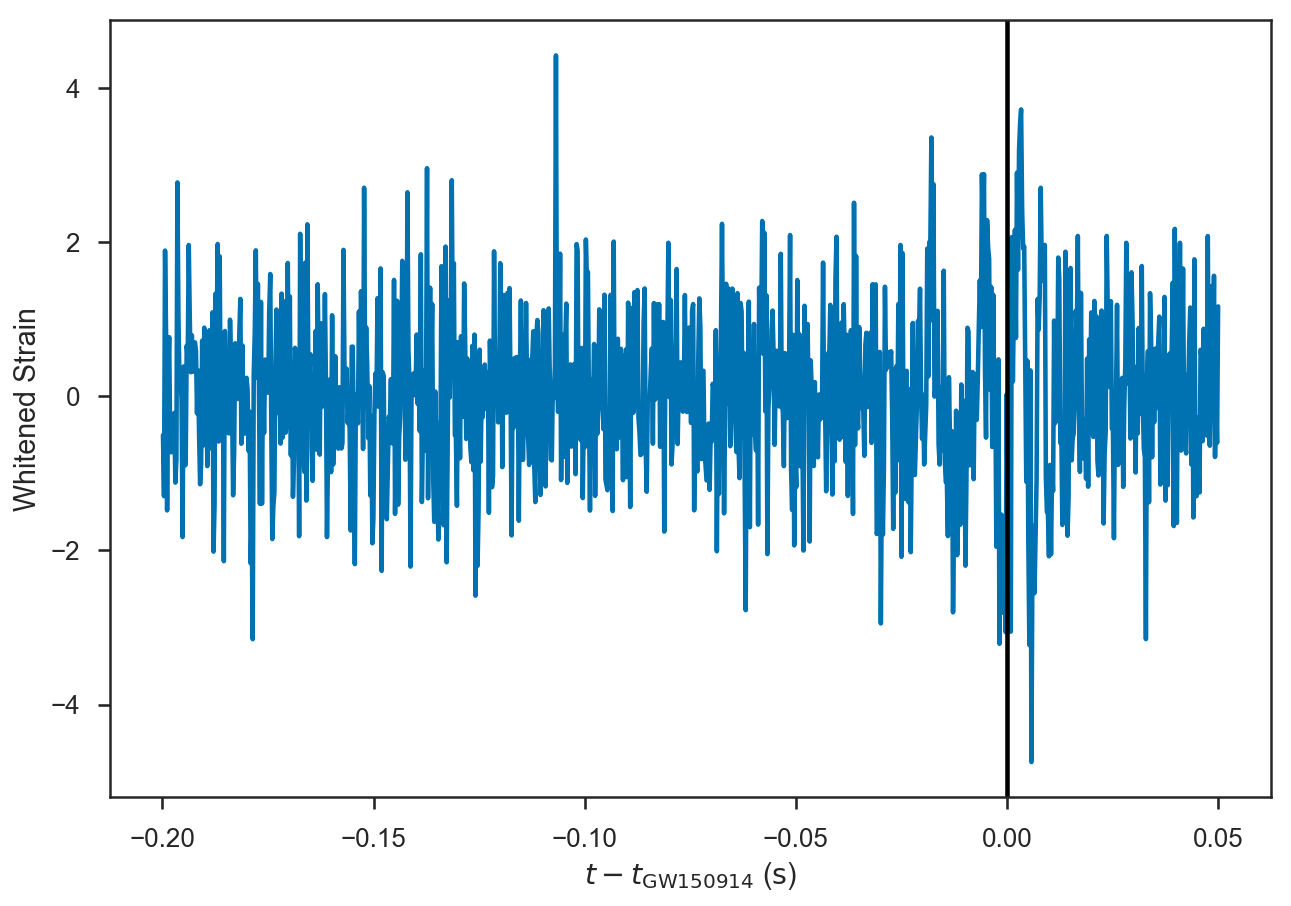

In [157]:
plot(time_h1[tselector]-tGW150914, white_strain_h1[tselector])
axvline(0.0, color='k')
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

There is lots of high-frequency noise here, but perhaps there is something where I have drawn the line.  Since we know that the signal is low-frequency (i.e. high-mass), let's low-pass filter it.

In [158]:
def low_pass_filter_amplitude(fs, frolloff, fwidth):
    return 1.0/(1.0 + exp((fs - frolloff)/fwidth))
def low_pass_filter(data, dt):
    Nt = data.shape[0]
    fs = np.fft.rfftfreq(Nt, dt)
    
    filt = low_pass_filter_amplitude(fs, 512.0, 16.0) # Rolloff at 512 Hz over 16 Hz
    
    dataf = np.fft.rfft(data)
    return np.fft.irfft(dataf*filt, Nt)

In [159]:
white_pass_strain_h1 = low_pass_filter(white_strain_h1, dt_sampling)

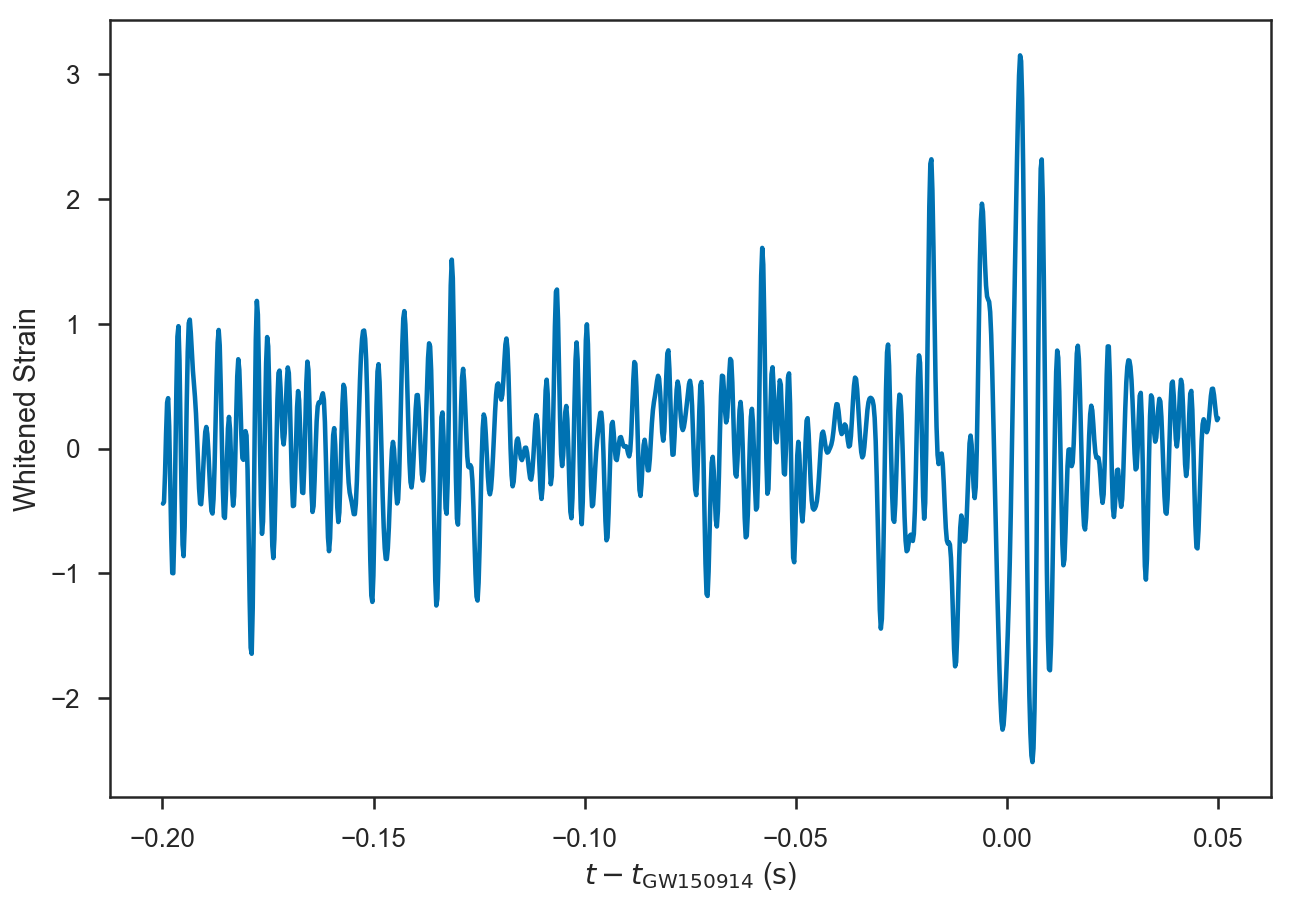

In [160]:
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

"Basic physics" paper discussion

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


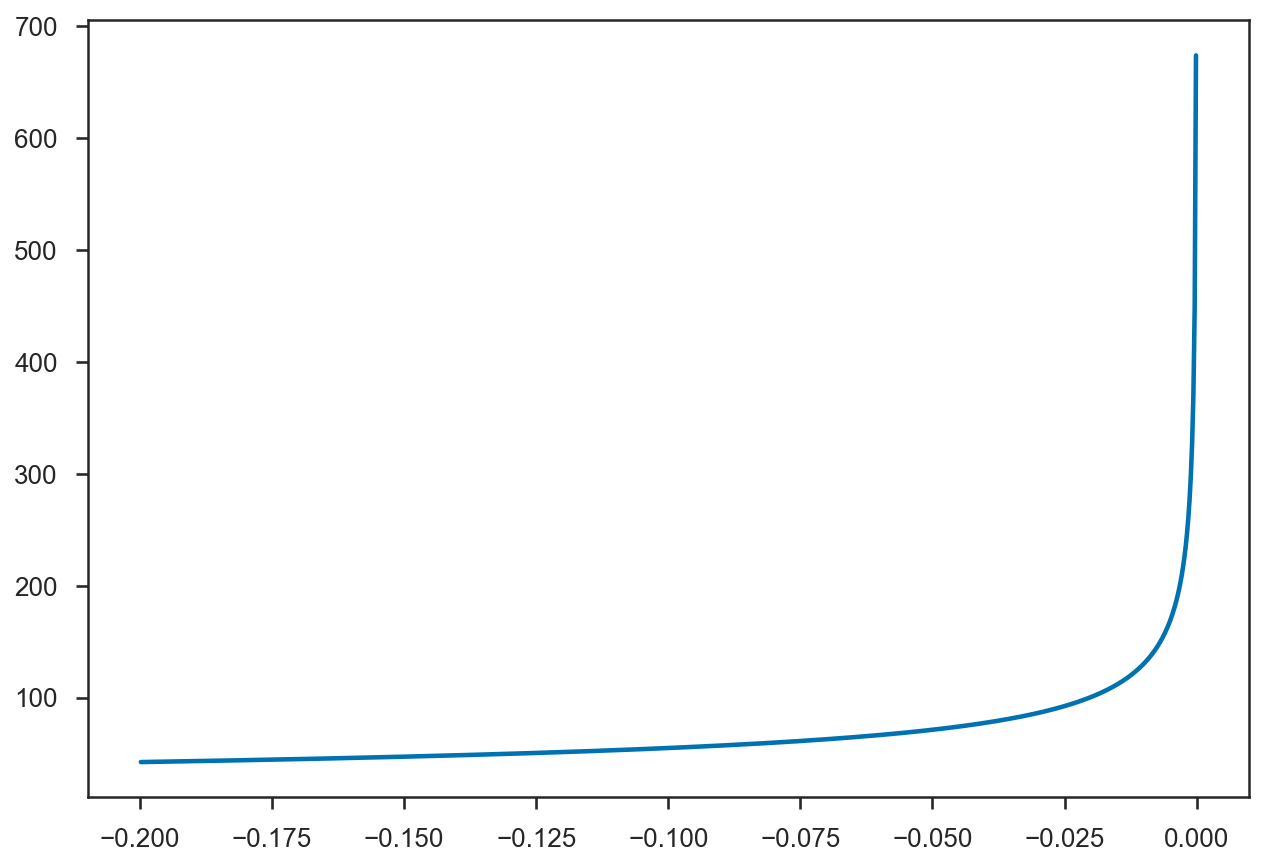

In [161]:
ts = time_h1[tselector]-tGW150914
fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)
plot(ts, fs)

In [173]:
def basic_waveform(ts, A100, dlnAdlnf, Mc, tc, phic, max_freq, tau):
    fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)
        
    fs[(fs >= max_freq) | (ts >= tc)] = max_freq
    
    amps = A100*(fs/100)**dlnAdlnf
    
    return (1.0-low_pass_filter_amplitude(fs, 30.0, 2.0))*amps*cos(phic + 2.0*pi*fs*(ts-tc))*low_pass_filter_amplitude(ts, tc, tau)

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


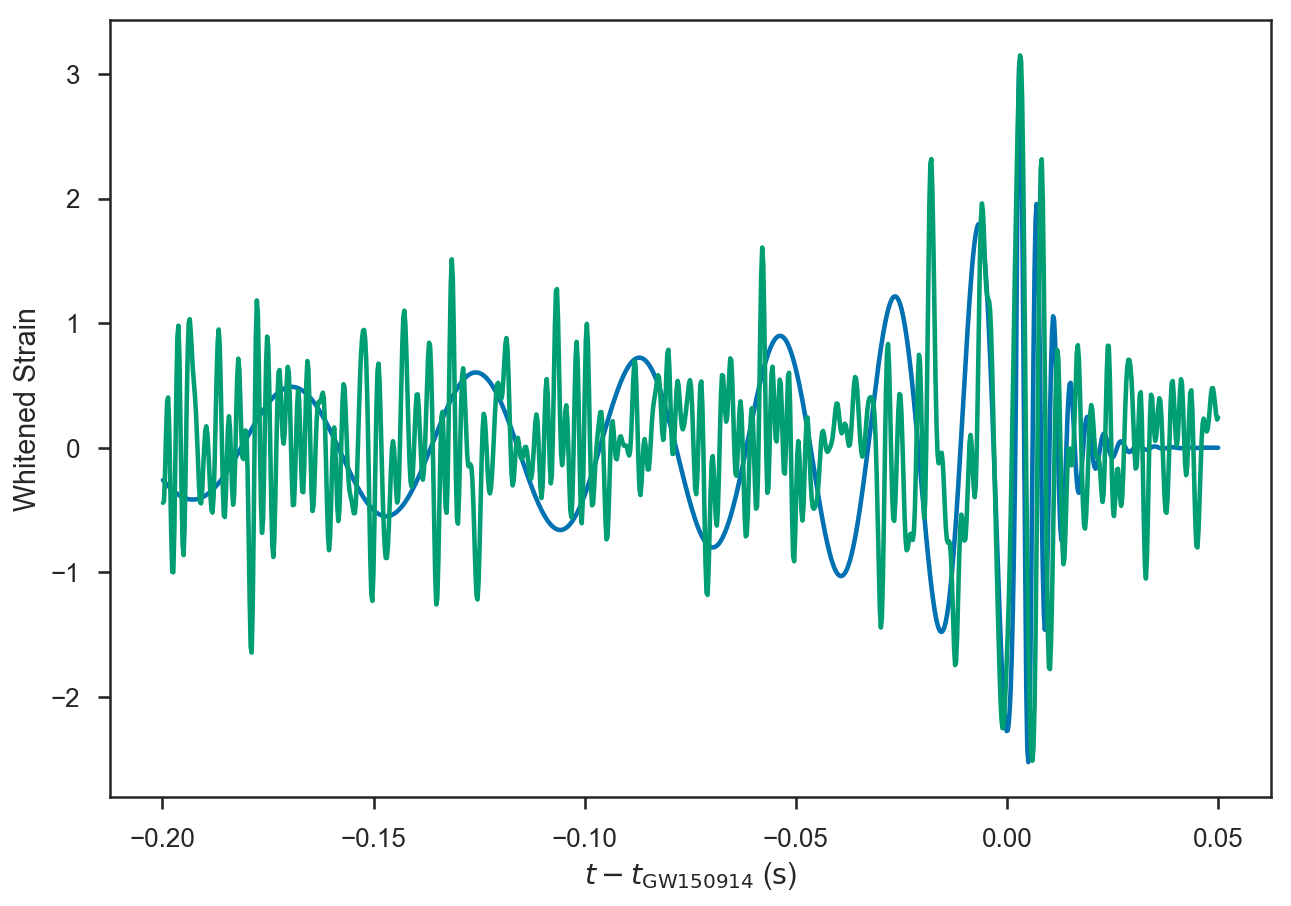

In [181]:
plot(time_h1[tselector]-tGW150914, basic_waveform(time_h1[tselector]-tGW150914, 2.0, 1.25, 30.0, 0.003, 0.0, 250.0, 0.005))
plot(time_h1[tselector]-tGW150914, white_pass_strain_h1[tselector])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

In [182]:
model = pystan.StanModel(file='phenom_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_65b7ed8120914fc3b3678723c2a64d3f NOW.


In [125]:
data = {
    'nt': sum(tselector),
    'ts': time_h1[tselector],
    'h_obs': strain_h1[tselector],
}

In [183]:
init = {
    'A100': 2.0,
    'dlnAdlnf': 1.25,
    'phic': 0.0,   
    'tc': 0.003,
    'Mc': 30.0,
    'max_freq': 250.0,
    'tau': 5e-3,
    'sigma': 0.4
}

In [184]:
fit = model.sampling(data=data, init=(init,)*4)
fit.plot()
fit

RuntimeError: Initialization failed.

 * What is our "just so" story?
 * How could we improve it?